## Appendix C. Non-numerical Clustering

This notebook contains the cluster analysis for the non-numerical features in order to obtain the common topics for different categories of viewership and engagement levels.

In [9]:
from PCA_and_Validation import cluster_range, plot_internal, PC_analysis
import warnings
warnings.filterwarnings("ignore")
import pickle
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

But first, clustering on numerical features must be done:

In [10]:

X_3 = pickle.load(open(f'/mnt/processed/private/msds2020/lt13/pickle/robustness_trials/T3', 'rb')) 

In [11]:
df_X3 = pd.DataFrame(X_3['posts'], columns = ['Id', 'PostTypeId', 'AcceptedAnswerId', 
                     'CreationDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId', 
                     'LastEditorUserId', 'LastEditDate', 'LastActivityDate', 
                     'Title', 'Tags', 'AnswerCount', 'CommentCount', 
                     'FavoriteCount', 'CommunityOwnedDate'])

In [12]:
X3_num = df_X3[['Score','ViewCount','AnswerCount','CommentCount','FavoriteCount']].fillna(0).astype(int)
X3_num['Score'] = X3_num['Score'].apply(lambda x: np.log(x+1-X3_num['Score'].min()))
X3_num['ViewCount'] = X3_num['ViewCount'].apply(lambda x: np.log(x+1))

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Xnum_data = MinMaxScaler().fit_transform(X3_num.to_numpy())
Xnum_data

array([[0.38346913, 0.42351782, 0.        , 0.03571429, 0.        ],
       [0.41598983, 0.53576353, 0.        , 0.21428571, 0.00959233],
       [0.37588586, 0.42557362, 0.08      , 0.17857143, 0.        ],
       ...,
       [0.47169235, 0.4256142 , 0.04      , 0.        , 0.00719424],
       [0.40392049, 0.38613342, 0.12      , 0.10714286, 0.00479616],
       [0.38346913, 0.47982782, 0.08      , 0.        , 0.        ]])

In [14]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)
Xnum_trunc = pca.fit_transform(Xnum_data)

In [15]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
kmeans_cluster = cluster_range(Xnum_data, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

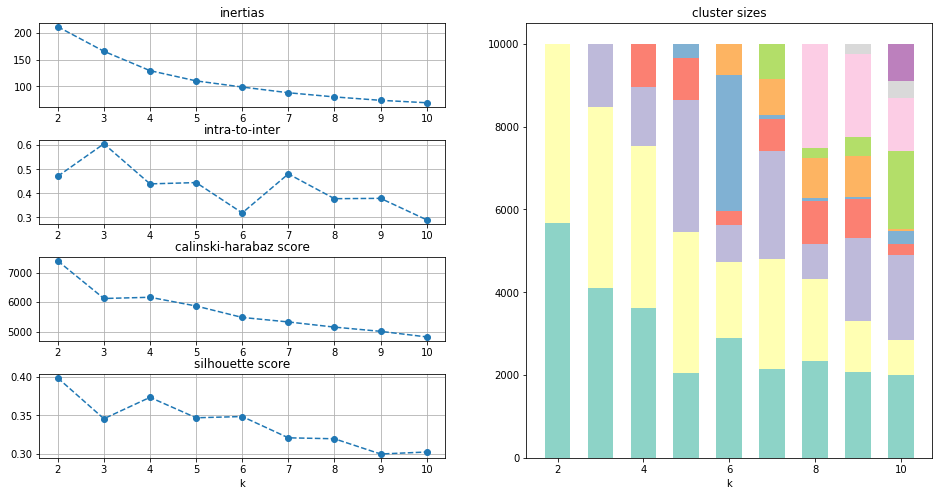

In [16]:
plot_internal(kmeans_cluster, k_start, k_stop);

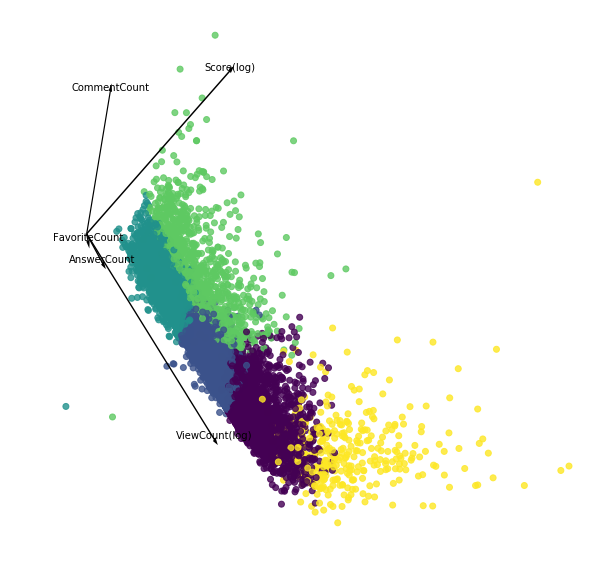

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xnum_trunc[:,0], Xnum_trunc[:,1], alpha=0.8, c=kmeans_cluster['ys'][3]);
#since TSNE doesn't preserve distances anyway, the axis labels doesn't matter
ax.set_axis_off(); 
x0, y0 = 0.2, 0.2
s = 0.5
for feat, feat_name in zip(pca.components_.T, ['Score(log)', 'ViewCount(log)',
                                               'AnswerCount', 'CommentCount',
                                               'FavoriteCount']):
    ax.arrow(x0, y0, s*feat[0], s*feat[1], color='k', width=0.003, ec='none')
    if not feat_name.endswith('(log)'):
        ax.text(x0+s*feat[0], y0+s*feat[1], feat_name, ha='center',
                 color='k')
    else:
        ax.text(x0+s*feat[0], y0+s*feat[1], feat_name, ha='center',
                 color='k')

From hereon, the clustering of non-numerical features will be performed. Note that for each cluster, vectorizing, internal validations, actual clustering, and inspection of the features for each cluster will be performed.

### Cluster 4

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(df_X3['Title'][kmeans_cluster['ys'][3]==4])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(df_X3['Tags'][kmeans_cluster['ys'][3]==4])

In [19]:
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)
X3_data.shape

(342, 871)

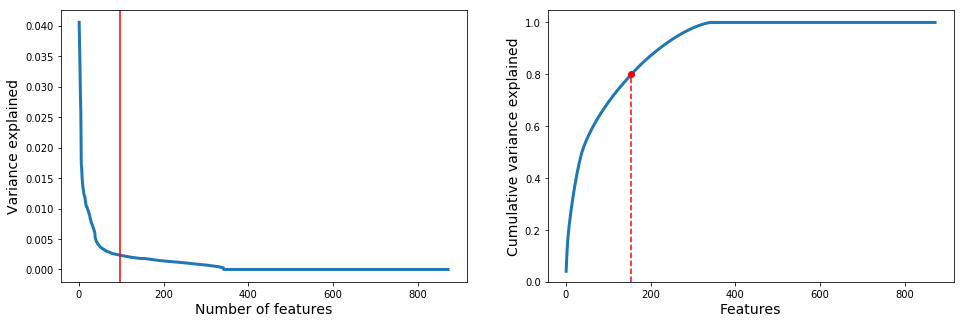

In [22]:
ax, n_PC = PC_analysis(X3_data);

In [25]:
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1, random_state=1337).fit_transform(X3_data)
#from sklearn.decomposition import NMF
#X3_bow_n = NMF(n_components=m, random_state=1337).fit_transform(X3_data)

In [26]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

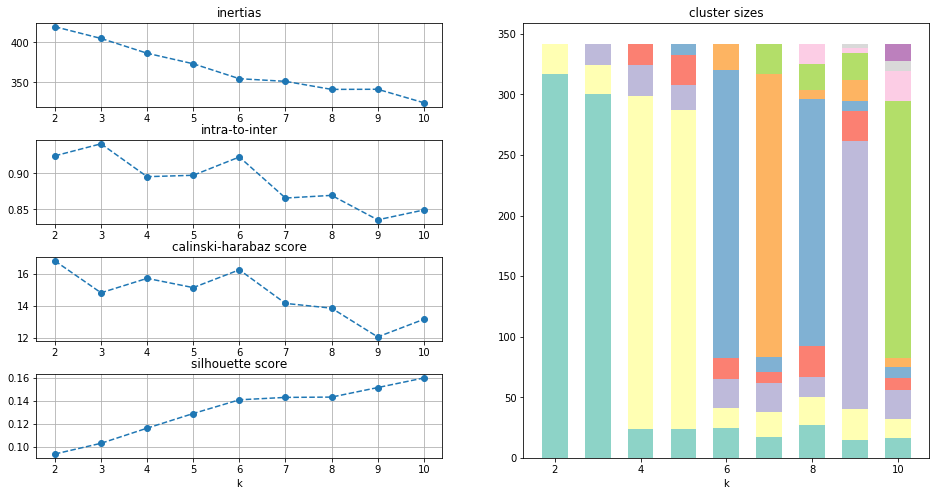

In [27]:
plot_internal(X3_kmeans_cluster, k_start, k_stop);

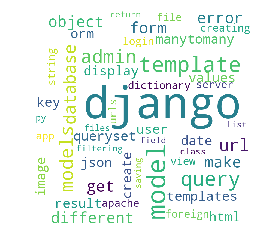

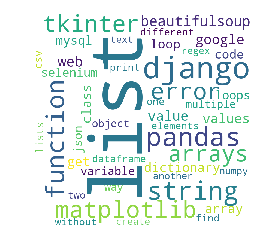

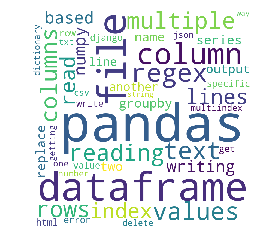

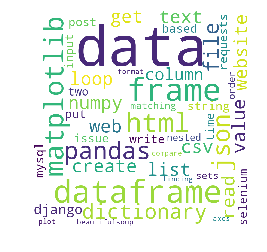

In [52]:
from wordcloud import WordCloud
k = 4
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          collocations = False).generate_from_frequencies(word_cld)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [ ]:
from wordcloud import WordCloud
from PIL import Image

k = 5
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k, k_stop=k)    
y_kmeans = X3_kmeans_cluster['ys'][0]
wordcloud = []
im = Image.open('Python_logo-512.png').convert('LA')
im_arr = np.array(im)

for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud.append(WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          colormap='YlOrRd',
                          mask=im_arr,
                          collocations = False).generate_from_frequencies(word_cld))

X3_bow_ts = TSNE(random_state=1337, perplexity=100).fit_transform(X3_bow_n)

pickle.dump(X3_bow_n, open('X3_bow_n4','wb'))
pickle.dump(X3_bow_ts, open('X3_bow_ts4','wb'))
pickle.dump(y_kmeans, open('y_kmeans4','wb'))
pickle.dump(wordcloud, open('wordcloud4','wb'))

In [184]:
 list(np.unique(X3_kmeans_cluster['ys'][0], return_counts=True)[1])

[24, 263, 21, 25, 9]

In [94]:
nonzeros = X3_data.sum(axis=1).nonzero()[0]
nonzeros.shape

(342,)

### Cluster 3

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(df_X3['Title'][kmeans_cluster['ys'][3]==3])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(df_X3['Tags'][kmeans_cluster['ys'][3]==3])

In [29]:
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)
X3_data.shape

(1025, 801)

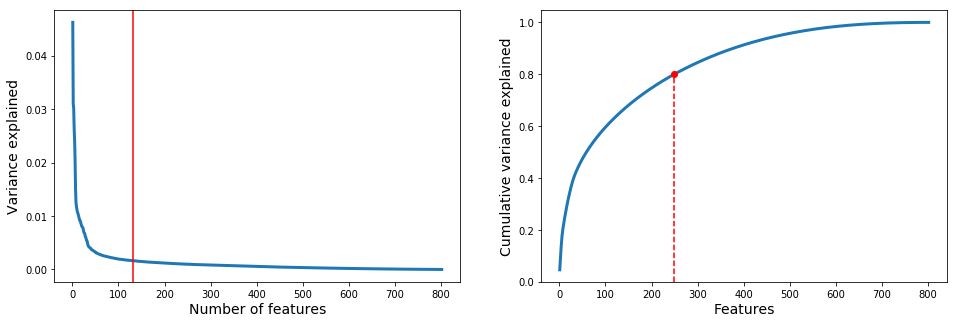

In [30]:
ax, n_PC = PC_analysis(X3_data);

In [31]:
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1, random_state=1337).fit_transform(X3_data)

In [32]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

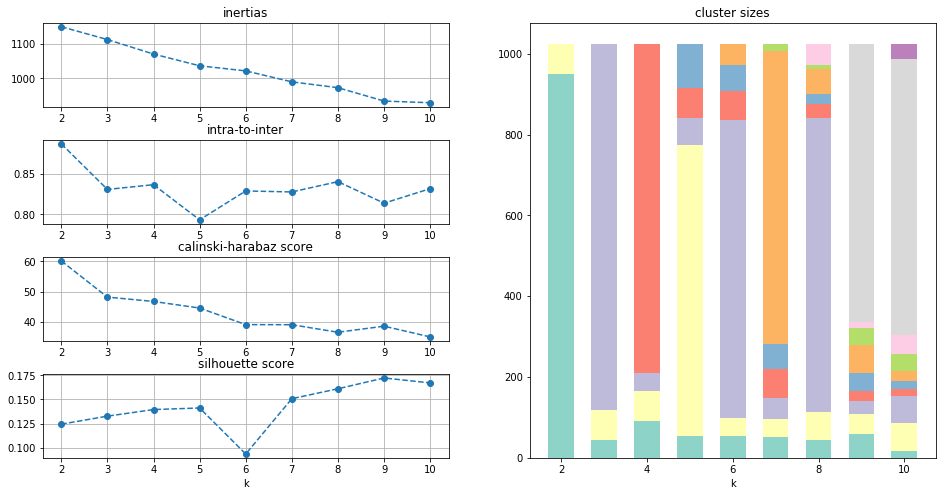

In [33]:
plot_internal(X3_kmeans_cluster, k_start, k_stop);

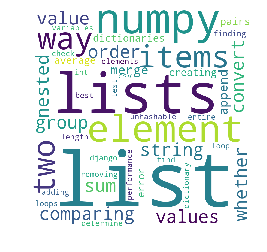

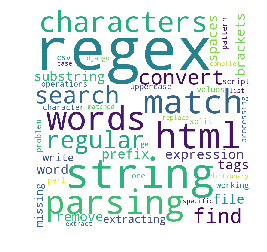

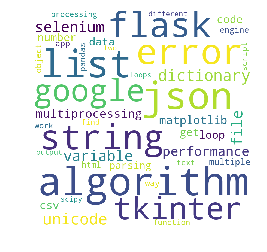

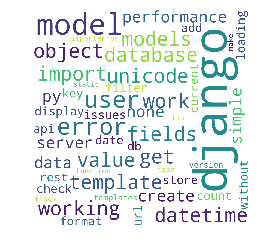

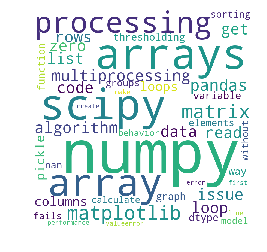

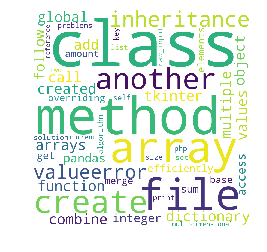

In [101]:
from wordcloud import WordCloud
k = 6
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          collocations = False).generate_from_frequencies(word_cld)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [189]:
from wordcloud import WordCloud
k = 6
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k, k_stop=k)    
y_kmeans = X3_kmeans_cluster['ys'][0]
wordcloud = []
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud.append(WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          colormap='YlOrRd',
                          collocations = False).generate_from_frequencies(word_cld))

X3_bow_ts = TSNE(random_state=1337, perplexity=100).fit_transform(X3_bow_n)

pickle.dump(X3_bow_n, open('X3_bow_n3','wb'))
pickle.dump(X3_bow_ts, open('X3_bow_ts3','wb'))
pickle.dump(y_kmeans, open('y_kmeans3','wb'))
pickle.dump(wordcloud, open('wordcloud3','wb'))

Executing k= 6


In [191]:
list(np.unique(X3_kmeans_cluster['ys'][0], return_counts=True)[1])

[53, 44, 767, 71, 67, 23]

### Cluster 0

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(df_X3['Title'][kmeans_cluster['ys'][3]==0])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(df_X3['Tags'][kmeans_cluster['ys'][3]==0])

In [35]:
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)
X3_data.shape

(2044, 905)

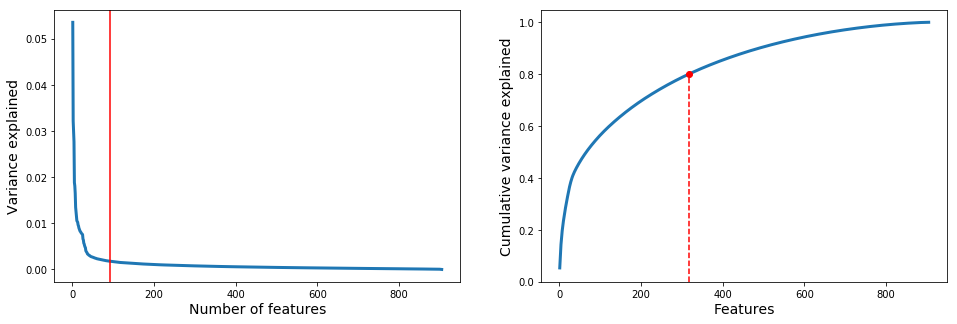

In [36]:
ax, n_PC = PC_analysis(X3_data);

In [37]:
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1, random_state=1337).fit_transform(X3_data)

In [38]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

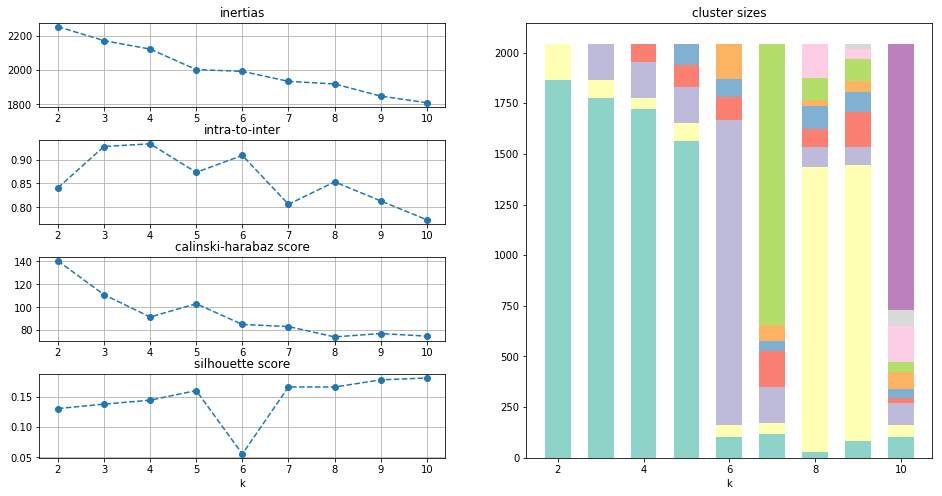

In [39]:
plot_internal(X3_kmeans_cluster, k_start, k_stop);

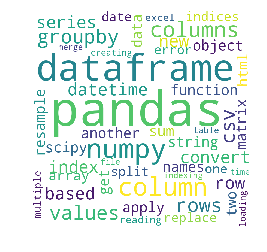

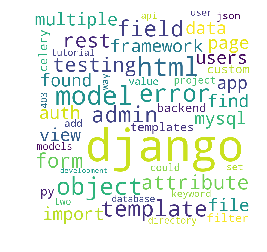

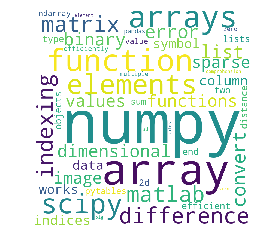

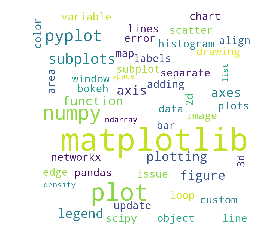

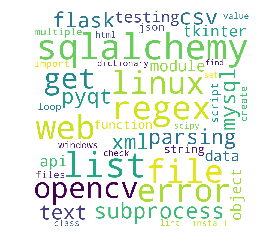

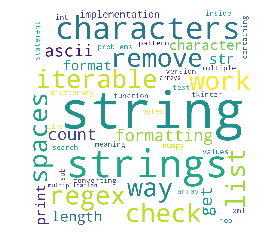

In [109]:
from wordcloud import WordCloud
k = 6
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          collocations = False).generate_from_frequencies(word_cld)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [196]:
from wordcloud import WordCloud
k = 6
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k, k_stop=k)    
y_kmeans = X3_kmeans_cluster['ys'][0]
wordcloud = []
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud.append(WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          colormap='YlOrRd',
                          collocations = False).generate_from_frequencies(word_cld))

X3_bow_ts = TSNE(random_state=1337, perplexity=100).fit_transform(X3_bow_n)

pickle.dump(X3_bow_n, open('X3_bow_n0','wb'))
pickle.dump(X3_bow_ts, open('X3_bow_ts0','wb'))
pickle.dump(y_kmeans, open('y_kmeans0','wb'))
pickle.dump(wordcloud, open('wordcloud0','wb'))

Executing k= 6


In [110]:
list(np.unique(X3_kmeans_cluster['ys'][4], return_counts=True)[1])

[110, 177, 100, 88, 1524, 45]

### Cluster 1

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(df_X3['Title'][kmeans_cluster['ys'][3]==1])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(df_X3['Tags'][kmeans_cluster['ys'][3]==1])

In [41]:
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)
X3_data.shape

(3414, 1043)

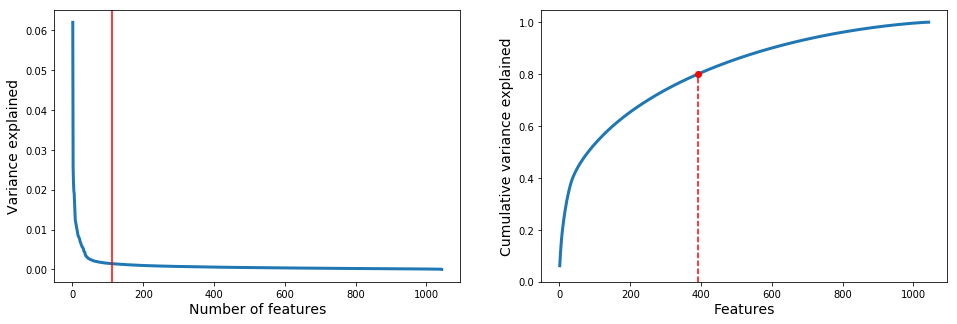

In [42]:
ax, n_PC = PC_analysis(X3_data);

In [43]:
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1, random_state=1337).fit_transform(X3_data)

In [44]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

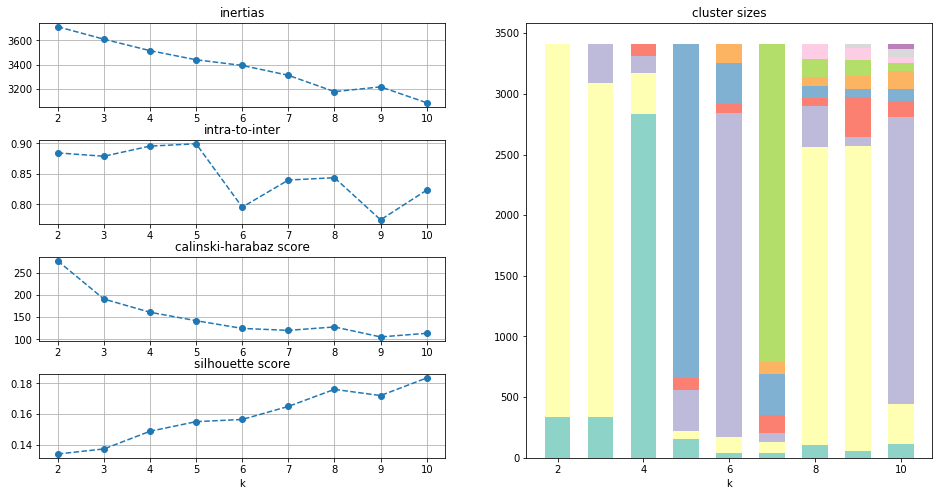

In [45]:
plot_internal(X3_kmeans_cluster, k_start, k_stop);

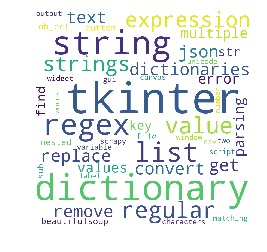

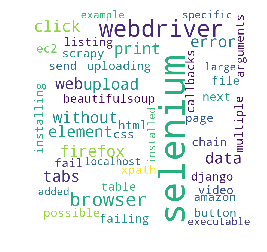

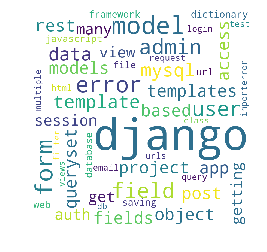

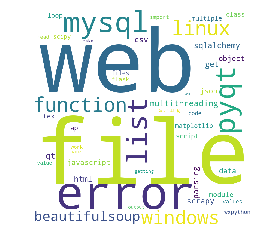

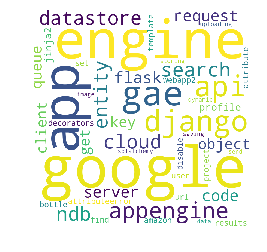

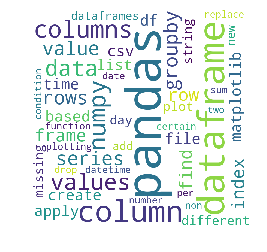

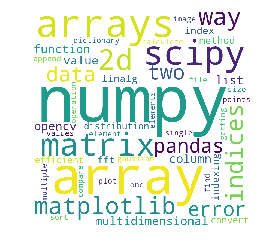

In [118]:
from wordcloud import WordCloud
k = 7
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          collocations = False).generate_from_frequencies(word_cld)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [201]:
from wordcloud import WordCloud
k = 7
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k, k_stop=k)    
y_kmeans = X3_kmeans_cluster['ys'][0]
wordcloud = []
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud.append(WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          colormap='YlOrRd',
                          collocations = False).generate_from_frequencies(word_cld))

X3_bow_ts = TSNE(random_state=1337, perplexity=100).fit_transform(X3_bow_n)

pickle.dump(X3_bow_n, open('X3_bow_n1','wb'))
pickle.dump(X3_bow_ts, open('X3_bow_ts1','wb'))
pickle.dump(y_kmeans, open('y_kmeans1','wb'))
pickle.dump(wordcloud, open('wordcloud1','wb'))

Executing k= 7


In [117]:
list(np.unique(X3_kmeans_cluster['ys'][5], return_counts=True)[1])

[244, 39, 336, 2395, 109, 158, 133]

### Cluster 2

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(df_X3['Title'][kmeans_cluster['ys'][3]==2])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(df_X3['Tags'][kmeans_cluster['ys'][3]==2])

In [47]:
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)
X3_data.shape

(3183, 859)

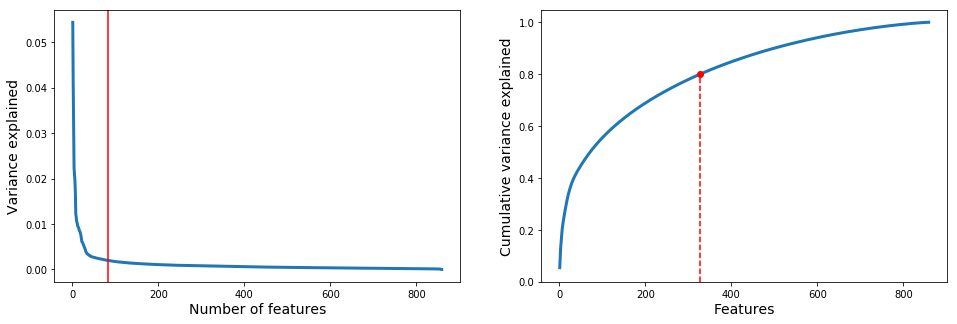

In [48]:
ax, n_PC = PC_analysis(X3_data);

In [49]:
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1, random_state=1337).fit_transform(X3_bow.toarray())

In [50]:
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

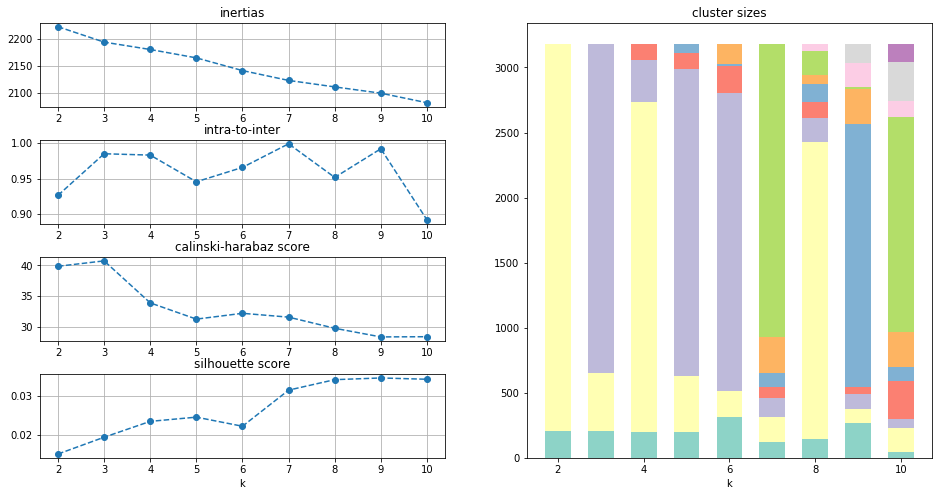

In [51]:
plot_internal(X3_kmeans_cluster, k_start, k_stop);

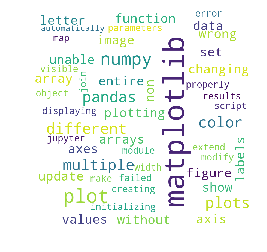

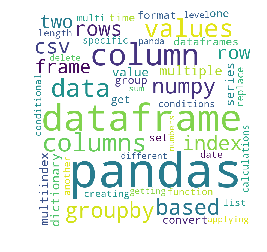

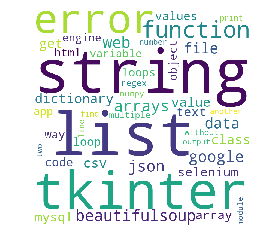

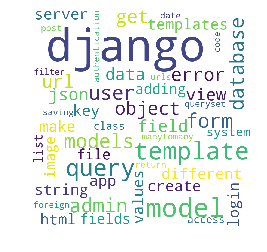

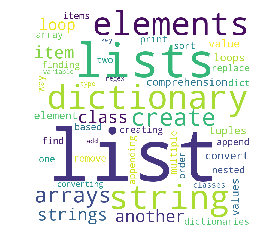

In [125]:
from wordcloud import WordCloud
k = 8
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          collocations = False).generate_from_frequencies(word_cld)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    

In [206]:
from wordcloud import WordCloud
k = 5
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k, k_stop=k)    
y_kmeans = X3_kmeans_cluster['ys'][0]
wordcloud = []
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud.append(WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          colormap='YlOrRd',
                          collocations = False).generate_from_frequencies(word_cld))

X3_bow_ts = TSNE(random_state=1337, perplexity=100).fit_transform(X3_bow_n)

pickle.dump(X3_bow_n, open('X3_bow_n2','wb'))
pickle.dump(X3_bow_ts, open('X3_bow_ts2','wb'))
pickle.dump(y_kmeans, open('y_kmeans2','wb'))
pickle.dump(wordcloud, open('wordcloud2','wb'))

Executing k= 5


In [212]:
list(np.unique(X3_kmeans_cluster['ys'][6], return_counts=True)[1])

[121, 283, 190, 1973, 146, 148, 188, 134]